In [478]:
import matplotlib.pyplot as plt
import numpy as np 
from scipy.io import loadmat
import pandas as pd
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score, confusion_matrix
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns

In [480]:
def show_results(model, X_test, y_test, labels_list):
    ypred = model.predict(X_test)
    mat = confusion_matrix(y_test, ypred) 
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                        xticklabels=labels_list,
                        yticklabels=labels_list)
    plt.xlabel('true label')
    plt.ylabel('predicted label');
    print('Accuracy: ', accuracy_score(y_test, ypred))
    print('F1: ', f1_score(y_test, ypred))
    print('Precision: ', precision_score(y_test, ypred))
    print('Recall: ', recall_score(y_test, ypred)) 

In [514]:
#load data chunks and convert to numpy
face = np.array(loadmat('./data/data.mat')['face'])
pose_raw = np.array(loadmat('./data/pose.mat')['pose'])
illum = np.array(loadmat('./data/illumination.mat')['illum'])

In [515]:
def make_pose_dataset_no_aug(pose_raw, num_subjects):
    pose_dataset = []
    pose_labels = []
    for subject in range(num_subjects):
        for pose in range(13):
            pose_dataset.append(pose_raw[:,:,pose,subject].reshape((48*40)))
            pose_labels.append(subject)
    pose_dataset = np.array(pose_dataset)
    pose_labels = np.array(pose_labels)
    return pose_dataset, pose_labels

In [498]:
def make_pose_dataset_with_aug(pose_raw, illum_raw, num_subjects):
    pose_dataset = []
    pose_labels = []
    for subject in range(num_subjects):
        for pose in range(13):
            pose_dataset.append(pose_raw[:,:,pose,subject].reshape((48*40)))
            pose_labels.append(subject)
    for subject in range(num_subjects):
        for pose in range(21):
            img = illum_raw[:,pose,subject].reshape((40,48))
            img = np.flip(np.rot90(img)).reshape((48*40))
            pose_dataset.append(img)
            pose_labels.append(subject)
    pose_dataset = np.array(pose_dataset)
    pose_labels = np.array(pose_labels)
    return pose_dataset, pose_labels

In [517]:
pose_data, pose_labels = make_pose_dataset_no_aug(pose, illum, 10)
print(pose_data.shape)
print(pose_labels.shape)

TypeError: make_pose_dataset_no_aug() takes 2 positional arguments but 3 were given

In [330]:
#split face data into parts
neutral= face[:,:,::3]
smile = face[:,:,1::3]
variation = face[:,:,2::3]

In [169]:
data = np.dstack((neutral,smile))
data = np.array(np.dsplit(data,data.shape[-1])).reshape((400,24,21))

In [170]:
data2 = np.dstack((neutral, variation, smile))
data2 = np.array(np.dsplit(data2,data2.shape[-1])).reshape((600,24,21))
data2 = data2/255
data2 = data2.reshape((600,24*21))

In [181]:
#make labels
labels = []
for i in range(200):
    labels.append(0)
for i in range(200):
    labels.append(1)
labels = np.array(labels)

In [182]:
#make labels2
labels2 = []
for i in range(400):
    labels2.append(0)
for i in range(200):
    labels2.append(1)
labels2 = np.array(labels2)

In [183]:
#transform
data = data/255
data = data.reshape((400,24*21))

In [187]:
#set dataset here
X_train, X_test, y_train, y_test = train_test_split(data2, labels2, test_size=0.3, random_state=42, shuffle='true', stratify=labels2)

In [189]:
print(y_test.shape)

(180,)


In [190]:
#TASK ONE:Bayes PIPELINE
pca = PCA()
gnb = GaussianNB()

pipe = Pipeline(steps=[('pca', pca), ('bayes', gnb)])

param_grid = {
    'pca__n_components': [i for i in range(1,40)]
}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
bayes_search = GridSearchCV(pipe, param_grid, scoring='accuracy', n_jobs=-1, cv=cv)
bayes_search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % bayes_search.best_score_)
print(bayes_search.best_params_)

Best parameter (CV score=0.907):
{'pca__n_components': 16}


Accuracy:  0.8777777777777778
F1:  0.8035714285714286
Precision:  0.8653846153846154
Recall:  0.75


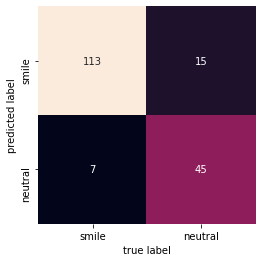

In [191]:
cm(bayes_search, X_test, y_test, ['smile','neutral'])

In [179]:
#TASK ONE:KNN PIPELINE
pca = PCA()
knn = KNeighborsClassifier()

pipe = Pipeline(steps=[('pca', pca), ('knn', knn)])

param_grid = {
    'pca__n_components': [i for i in range(1,31)],
    'knn__n_neighbors' : [i for i in range(1,11)],  
    'knn__metric' : ['euclidean','manhattan','chebyshev','minkowski','wminkowski','seuclidean','mahalanobis'],
    'knn__weights' : ['uniform','distance'],
    
}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
knn_search = GridSearchCV(pipe, param_grid, scoring='accuracy', cv=cv, n_jobs=-1)
knn_search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % knn_search.best_score_)
print(knn_search.best_params_)

Best parameter (CV score=0.897):
{'knn__metric': 'manhattan', 'knn__n_neighbors': 9, 'knn__weights': 'uniform', 'pca__n_components': 7}


Accuracy:  0.9040404040404041
F1:  0.8480000000000001
Precision:  0.8983050847457628
Recall:  0.803030303030303


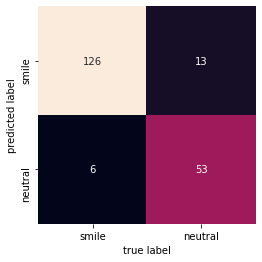

In [180]:
cm(knn_search, X_test, y_test, ['smile','neutral'])

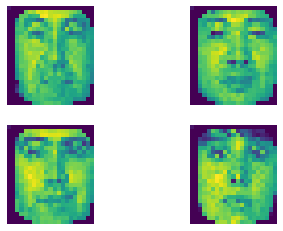

In [632]:
# plt.figure((20,20))
for i in range(4):
    # define subplot
    plt.subplot(2, 2, 1 + i)
    # turn off axis
    plt.axis('off')
    # plot raw pixel data
    plt.imshow(X[i].reshape((24,21)))

In [509]:
#set dataset here
X_train, X_test, y_train, y_test = train_test_split(pose_data, pose_labels, test_size=0.3, random_state=42, shuffle='true', stratify=pose_labels)
print(X_train.shape)
print(X_test.shape)

(238, 1920)
(102, 1920)


In [510]:
#TASK TWO Bayes
pca = PCA()
gnb = GaussianNB()

pipe = Pipeline(steps=[('pca', pca), ('bayes', gnb)])

param_grid = {
    'pca__n_components': [i for i in range(1,40)]
}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
bayes_search = GridSearchCV(pipe, param_grid, scoring='accuracy', n_jobs=-1, cv=5)
bayes_search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % bayes_search.best_score_)
print(bayes_search.best_params_)

Best parameter (CV score=0.861):
{'pca__n_components': 32}


In [409]:
illum.shape

(1920, 21, 68)

In [447]:
ds = np.array(ill_data)
ds.shape

(1428, 48, 40)

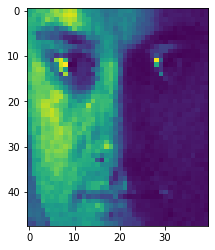

In [471]:
plt.imshow(ds[22])

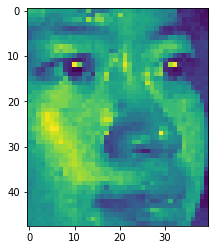

In [466]:
plt.imshow(pose_data[].reshape((48,40)))